# Connecting to your data

In [1]:
import datajoint as dj

## Open connection to a database server instance i.e. Pipeline

In [2]:
# dj.conn(host='db', user='root', password='coogs')
dj.conn()

Connecting root@db:3306


DataJoint connection (connected) root@db:3306

In [3]:
dj.list_schemas()

['mysql', 'performance_schema', 'sys']

# Structuring your data using a database i.e. Schema

In [4]:
schema = dj.Schema('{user}_uh-showcase'.format(user=dj.config['database.user']))
schema

Schema `root_uh-showcase`

In [5]:
dj.Diagram(schema)

In [6]:
@schema
class Sport(dj.Manual):
    definition = """
    sport_id        :  int auto_increment
    ---
    name      : varchar(30)
    sex="men" : enum("women", "men")
    unique index(name, sex)
    """

In [7]:
Sport.insert([
    dict(name='swim', sex='women'),
    dict(name='soc', sex='women')
])
Sport.insert([
    dict(name='track'),
    dict(name='football')
])

In [8]:
Sport()

sport_id,name,sex
4,football,men
2,soc,women
1,swim,women
3,track,men


In [9]:
Sport & dict(sex='women')

sport_id,name,sex
2,soc,women
1,swim,women


In [10]:
q = Sport & "sex='men'"
q

sport_id,name,sex
4,football,men
3,track,men


In [11]:
q.fetch(order_by='name DESC', format='frame')

,name,sex
sport_id,,
3,track,men
4,football,men


In [12]:
q.fetch()

array([(4, 'football', 'men'), (3, 'track', 'men')],
      dtype=[('sport_id', '<i8'), ('name', 'O'), ('sex', 'O')])

In [13]:
Sport - dict(sex='men')

sport_id,name,sex
2,soc,women
1,swim,women


In [14]:
(Sport - dict(sex='men')).make_sql()

'SELECT `sport_id`,`name`,`sex` FROM `root_uh-showcase`.`sport` WHERE(NOT ((`sex`="men")))'

In [15]:
from datetime import date

In [16]:
@schema
class NewsArticle(dj.Manual):
    definition = """
    -> Sport
    news_id       : int
    ---
    date=null: date
    """

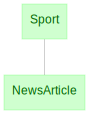

In [17]:
dj.Di(schema)

In [18]:
NewsArticle.insert([
    # [4, 2, date(2020,3,3)],
    [2, 2, date(2019,11,5)],
    [1, 2, date(2020,3,11)],
    [3, 2, date(2020,3,4)],
])
# NewsArticle.insert([
#     dict(sport_id=1, news_id=1),
#     dict(sport_id=3, news_id=1)
# ])
# NewsArticle.insert([
#     [4, 1, date(2021,1,29)],
#     [2, 1, date(2021,4,9)],
#     [1, 1, date(2021,3,20)],
#     [3, 1, date(2021,4,8)],
# ])

In [19]:
NewsArticle()

sport_id,news_id,date
1,2,2020-03-11
2,2,2019-11-05
3,2,2020-03-04


In [20]:
Sport * NewsArticle

sport_id,news_id,name,sex,date
1,2,swim,women,2020-03-11
2,2,soc,women,2019-11-05
3,2,track,men,2020-03-04


In [21]:
from requests import request
import json
from os import path, mkdir
from bs4 import BeautifulSoup
from datetime import datetime

In [22]:
@schema
class Headline(dj.Imported):
    definition = """
    -> NewsArticle
    ---
    name : varchar(200)
    image: longblob
    """
    def make(self, key):    
        sport_name, sport_sex = (Sport & key).fetch1('name', 'sex')
        news_date = (NewsArticle & key).fetch1('date')
        file_path = 'cached/{}_{}_{}.jpg'.format(sport_name, sport_sex, news_date)

        if not path.exists(file_path):
            base_url = "https://uhcougars.com"
            headers = {
                'User-Agent': "DataJoint"
            }
            querystring = {
                "index":"1",
                "page_size":"200",
                "sport": sport_name if sport_sex != 'women' else sport_sex[0] + sport_name,
                "season":"0"
            }
            response = request("GET", base_url + "/services/archives.ashx/stories",
                               headers=headers, params=querystring)
            article = ([v for v in json.loads(response.text)['data']
                        if v['story_postdate'] == news_date.strftime("%-m/%-d/%Y")][0]
                       if news_date else json.loads(response.text)['data'][0])
            news_date = (datetime.strptime(article['story_postdate'],
                                           '%m/%d/%Y').date()
                         if not news_date else news_date)

            htmldata = request("GET", base_url + article['story_path'], headers=headers).text
            soup = BeautifulSoup(htmldata, 'html.parser')
#             print([i['src'] for i in soup.find_all('img') if i.has_attr('src')])
            image_path = [i['src'] for i in soup.find_all('img') if i.has_attr('src')][2]
            response = request("GET", image_path, headers=headers)
            if not path.exists(path.dirname(file_path)):
                mkdir(path.dirname(file_path))
            with open(file_path, 'wb') as f:
                f.write(response.content)
            print('Image `{}` downloaded.'.format(file_path))
            key['name'] = article['story_headline']
        else:
            key['name'] = 'No Title (loaded from cache)'
            print('Image `{}` read from cache.'.format(file_path))

        with open(file_path, mode='rb') as f:
            key['image'] = f.read()
        self.insert1(key)

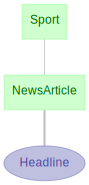

In [23]:
dj.Di(schema)

In [26]:
Headline()

sport_id,news_id,name,image
1,2,Houston Concludes NCAA Zone D Diving Championships,=BLOB=
2,2,Bowen and Grant Earn Regular Season Honors,=BLOB=
3,2,Three Cougars Tabbed As Most Outstanding Performers,=BLOB=


In [25]:
Headline.populate(display_progress=True)

Headline:  33%|███▎      | 1/3 [00:01<00:03,  1.86s/it]

Image `cached/swim_women_2020-03-11.jpg` downloaded.
Image `cached/soc_women_2019-11-05.jpg` downloaded.


Headline: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]

Image `cached/track_men_2020-03-04.jpg` downloaded.


In [27]:
q_original = Headline()
q_original = Headline & dict(sport_id=1, news_id=2)
q_original

sport_id,news_id,name,image
1,2,Houston Concludes NCAA Zone D Diving Championships,=BLOB=


In [28]:
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

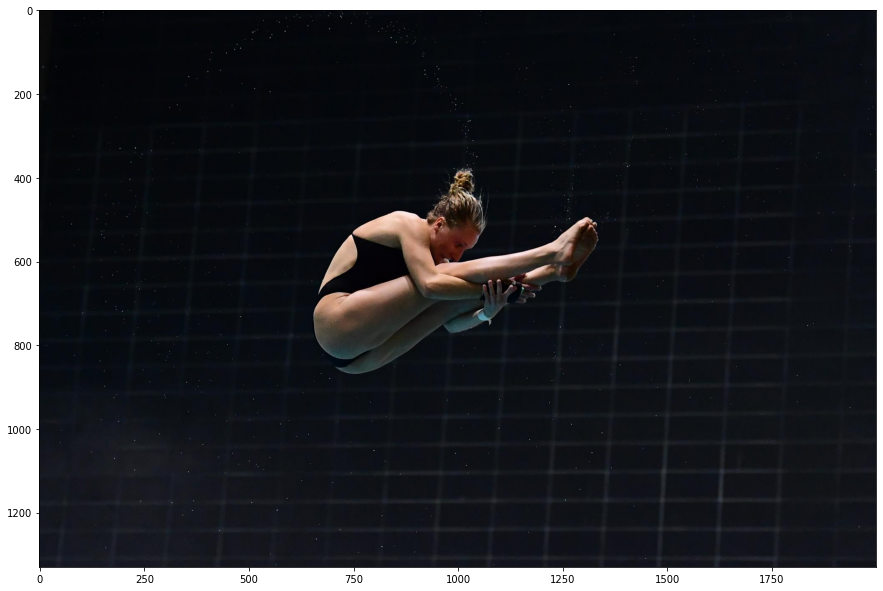

In [29]:
image_original = q_original.fetch1('image')
image_original = Image.open(BytesIO(image_original))
fig, axarr = plt.subplots(1,1,figsize=(15,15))
axarr.imshow(image_original)

In [30]:
@schema
class PaintingStyle(dj.Lookup):
    definition = """
    style_name      : varchar(30)
    """
    contents = [
        ['udnie']
    ]

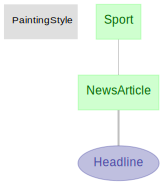

In [31]:
dj.Di(schema)

In [32]:
PaintingStyle.insert([
    dict(style_name='mosaic')
])

In [33]:
PaintingStyle()

style_name
mosaic
udnie


In [34]:
import numpy as np
import cv2
import imutils

In [35]:
@schema
class Flyer(dj.Computed):
    definition = """
    -> Headline
    -> PaintingStyle
    ---
    image: longblob
    """
    def make(self, key):
        style_path = 'models/' + key['style_name'] + '.t7'
        image = (Headline & key).fetch1('image')
        
        net = cv2.dnn.readNetFromTorch(style_path)
        image = np.frombuffer(image, np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        image = imutils.resize(image, width=600)
        (h, w) = image.shape[:2]

        # construct a blob from the image, set the input, and then perform a
        # forward pass of the network
        blob = cv2.dnn.blobFromImage(image, 1.0, (w, h),
            (103.939, 116.779, 123.680), swapRB=False, crop=False)
        net.setInput(blob)
        output = net.forward()

        # reshape the output tensor, add back in the mean subtraction, and
        # then swap the channel ordering
        output = output.reshape((3, output.shape[2], output.shape[3]))
        output[0] += 103.939
        output[1] += 116.779
        output[2] += 123.680
        output = output.transpose(1, 2, 0)
        output = np.clip(output, 0, 255)
        output= output.astype('uint8')
        
        print('sport_id: {sport_id}, news_id: {news_id}, style_name: {style_name}'.format(**key))
        
        key['image'] = cv2.imencode('.jpg', output)[1].tobytes()
        self.insert1(key)

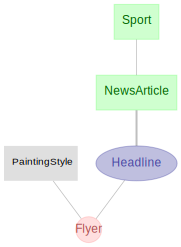

In [36]:
dj.Di(schema)

In [37]:
Flyer.populate()

Flyer:  17%|█▋        | 1/6 [00:01<00:05,  1.13s/it]

sport_id: 1, news_id: 2, style_name: mosaic


Flyer:  33%|███▎      | 2/6 [00:02<00:04,  1.02s/it]

sport_id: 1, news_id: 2, style_name: udnie


Flyer:  50%|█████     | 3/6 [00:02<00:02,  1.05it/s]

sport_id: 2, news_id: 2, style_name: mosaic


Flyer:  67%|██████▋   | 4/6 [00:03<00:01,  1.05it/s]

sport_id: 2, news_id: 2, style_name: udnie


Flyer:  83%|████████▎ | 5/6 [00:04<00:00,  1.04it/s]

sport_id: 3, news_id: 2, style_name: mosaic


Flyer: 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

sport_id: 3, news_id: 2, style_name: udnie


In [41]:
q_styled = Flyer()
# q_styled = Flyer & dict(sport_id=1, news_id=2, style_name='udnie')
q_styled = Flyer & dict(sport_id=1, news_id=2, style_name='mosaic')
q_styled

sport_id,news_id,style_name,image
1,2,mosaic,=BLOB=


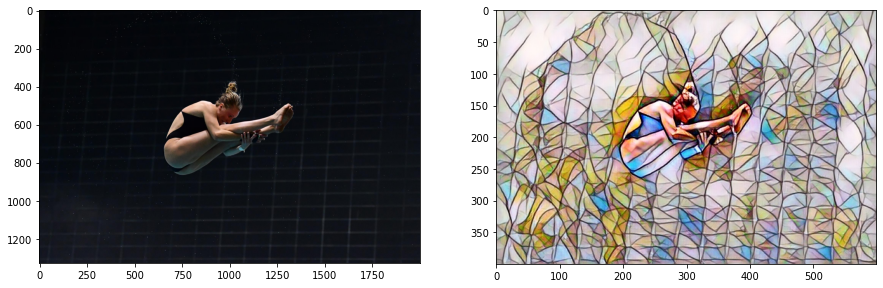

In [42]:
image_styled = q_styled.fetch1('image')
image_styled = Image.open(BytesIO(image_styled))

fig, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(image_original)
axarr[1].imshow(image_styled)

In [ ]:
image_styled.save("./image_styled.jpg", 'jpeg')

# Clean up and remove generated data

In [ ]:
schema.drop()

In [ ]:
import shutil
shutil.rmtree('cached')

In [ ]:
import os
os.unlink("./image_styled.jpg")